# Fun wuth Gamma Ray Bursts

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.visualization.hist import hist as fancyhist

In [3]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



In [4]:
names


array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [5]:
print(data[6])

# Duration of the time interval during which 90% of the GRB photon counts are observed
T90 = np.array(data[6], dtype = float)
T90_err = np.array(data[names=='T90_error'][0],dtype=float)

ra = np.array(data[3], dtype = float)

decl = np.array(data[4], dtype = float)

fluence = np.array (data[9], dtype = float)
fluence_err = np.array(data[names=='fluence_error'][0],dtype=float)

z =  np.array(data[11], dtype = float)   # we don't know selection effects of long gamma ray burst... 

T100 =  np.array(data[12], dtype = float)

#print(data[13])

['-999' '0.8320' '1.4720' ... '3.1360' '208.5760' '5.1840']


plt.scatter(ra, np.cos(decl), s= 1)
plt.show()

In [6]:
T90_mask = T90 > 0
fluence_mask = fluence > 0
mask = T90_mask & fluence_mask

T90_masked = np.array( T90[mask], dtype = float)
fluence_masked = np.array(fluence[mask], dtype = float)
z_masked = np.array(z[mask], dtype = float)
decl_masked = np.array(decl[mask], dtype = float)
ra_masked = np.array(ra[mask], dtype = float)

#T90_err_masked = np.array(T90_err[mask], dtype = float)
#fluence_err_masked = np.array(fluence_err[mask], dtype = float)


print(len(T90_masked))


7348


### Let's first have a look at the data

Text(0.5, 0, 'redshift')

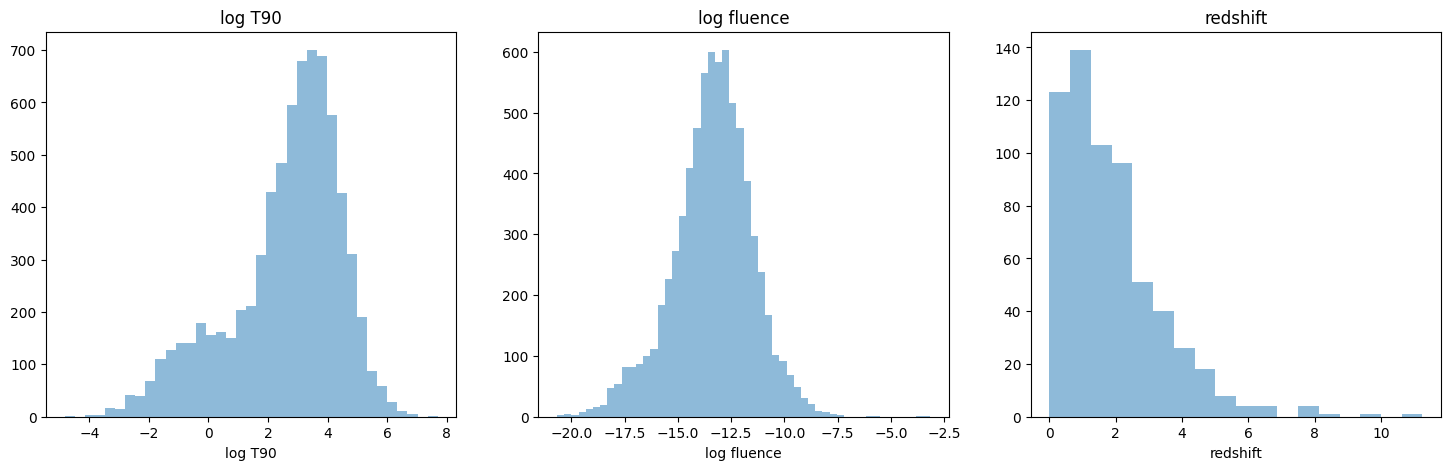

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for T90
fancyhist(np.log(T90_masked), bins='scott', ax=axs[0], alpha=0.5)
axs[0].set_title('log T90')
axs[0].set_xlabel('log T90')

# Histogram for fluence
fancyhist(np.log(fluence_masked), bins='scott', ax=axs[1], alpha = 0.5)
axs[1].set_title('log fluence')
axs[1].set_xlabel('log fluence')

# Histogram for redshift
fancyhist(z[z > 0], bins='scott', ax=axs[2], alpha = 0.5)
axs[2].set_title('redshift')
axs[2].set_xlabel('redshift')


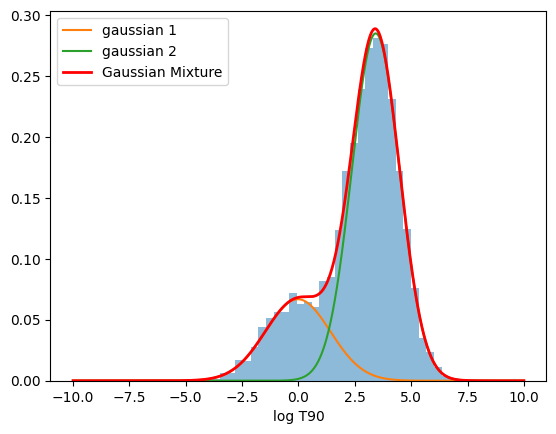

In [8]:
#looking at the T90 distribution:

from sklearn.mixture import GaussianMixture
from scipy.stats import norm

log_T90 = np.log(T90_masked).reshape(-1,1)

gm = GaussianMixture(n_components=2, random_state=0).fit(log_T90)
#print(gm.means_)

x= np.linspace(-10, 10, 1000).reshape(-1,1)

gaussian_1 = norm.pdf(x, gm.means_[0], np.sqrt(gm.covariances_[0]))
gaussian_2 = norm.pdf(x, gm.means_[1], np.sqrt(gm.covariances_[1]))

# I then need to multiply by the weights....

fancyhist(log_T90, bins='scott', alpha=0.5, density = True)
plt.xlabel('log T90')


plt.plot(x, gaussian_1* gm.weights_[0], label='gaussian 1')
plt.plot(x, gaussian_2 * gm.weights_[1],  label='gaussian 2')

plt.plot(x, np.exp(gm.score_samples(x)), label='Gaussian Mixture', color='red', linewidth=2)
plt.legend()

In [9]:
### Probability of GRBs being in the first and second Gaussian

probabilities = gm.predict_proba(log_T90)
#print(probabilities)
more_probable_gaussian = np.argmax(probabilities, axis=1)

print("number of GRBs more probable in gaussian 1:", np.sum(more_probable_gaussian == 0))
print("number of GRBs in gaussian 2:", np.sum(more_probable_gaussian == 1))
print('----------------------')
print("It's more probable to observe long Gamma Ray Bursts !!\n It can be due to selection effects")

number of GRBs more probable in gaussian 1: 1600
number of GRBs in gaussian 2: 5748
----------------------
It's more probable to observe long Gamma Ray Bursts !!
 It can be due to selection effects


In [10]:
#let's find the intersection between the gaussians
x_intersec = np.linspace(0, 4, 100).reshape(-1,1) 
gaussian_1_intersec = norm.pdf(x_intersec, gm.means_[0], np.sqrt(gm.covariances_[0]))
gaussian_2_intersec = norm.pdf(x_intersec, gm.means_[1], np.sqrt(gm.covariances_[1]))

intersection = np.exp(x_intersec[np.argmin(np.abs(gaussian_1_intersec * gm.weights_[0] - 
                                         gaussian_2_intersec * gm.weights_[1]))])
print("log threshold between the two gaussians: ", np.log(intersection[0]))
print("Threshold between the two gaussians: ", intersection[0]) 

#while means are:
mean_1 = np.exp(gm.means_[0])
mean_2 = np.exp(gm.means_[1])

log threshold between the two gaussians:  1.3333333333333335
Threshold between the two gaussians:  3.7936678946831783


### but the border found with Gaussian mixture might not be the best choice looking at more dimentions

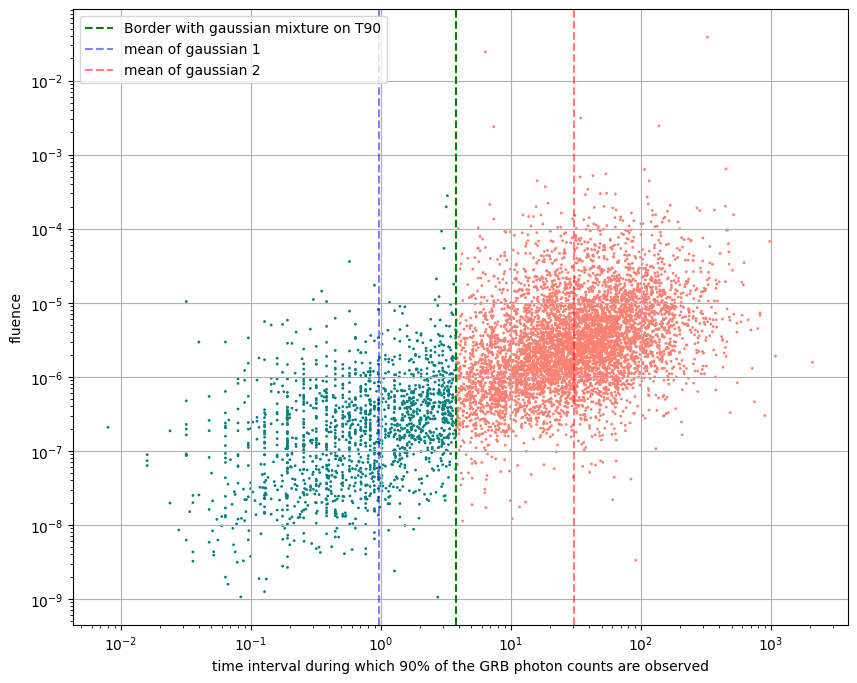

In [11]:
plt.figure(figsize=(10, 8))

# Color points differently based on the intersection
colors = ['teal' if t < intersection else 'salmon' for t in T90[mask]]

plt.scatter(T90[mask], fluence[mask], s=1, c=colors)

plt.axvline(intersection, color='green', linestyle='--', label='Border with gaussian mixture on T90')
plt.axvline(mean_1, color='blue', linestyle='--',alpha = 0.5, label='mean of gaussian 1')
plt.axvline(mean_2, color='red', linestyle='--', alpha= 0.5, label='mean of gaussian 2')

plt.legend()
plt.xlabel("time interval during which 90% of the GRB photon counts are observed")
plt.ylabel("fluence")
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()

## KMeans

(7348, 2)
CLUSTER CENTERS: [[  3.51883222 -12.56552651]
 [  0.1700901  -15.47054144]]


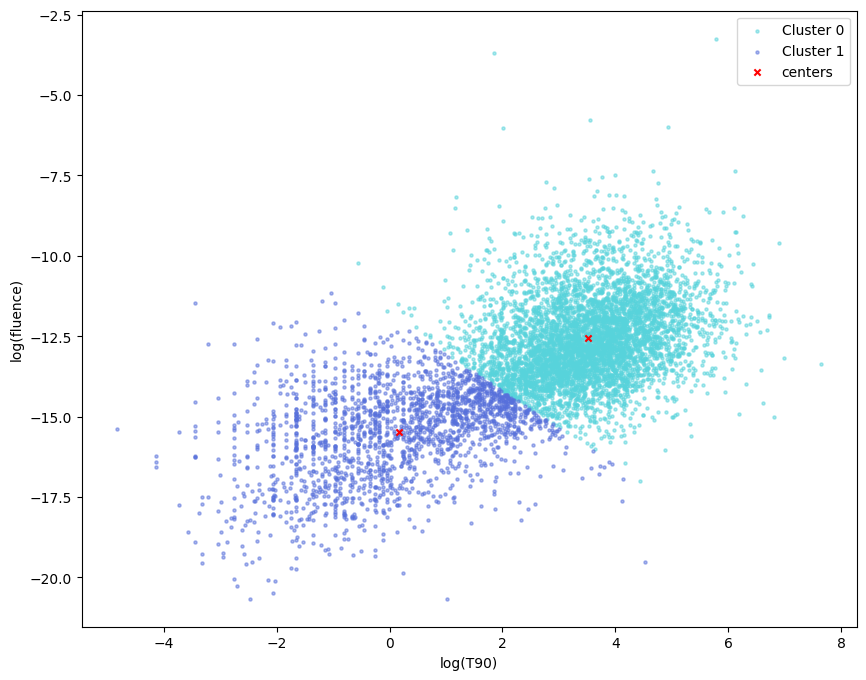

In [12]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

X = np.array([np.log(T90_masked), np.log(fluence_masked)]).T
print(X.shape)


clf = KMeans(n_clusters=2) 
clf.fit(X)
centers = clf.cluster_centers_ 
labels = clf.predict(X) 
plt.figure(figsize = (10,8))

colors = sns.color_palette("hls", 8)[4:]
for ii in range(2):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5, s= 5, label = 'Cluster %i'%ii)

plt.scatter(centers[:,0], centers[:,1], color='red', marker='x', s=20, label='centers')

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('log(T90)')
plt.ylabel('log(fluence)')
plt.legend()

print("CLUSTER CENTERS:", centers)

## MeanShift

In [13]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift

scaler = preprocessing.StandardScaler()
bandwidth = 0.5
#bandwidth = estimate_bandwidth(X_reduced) 
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(X))

MeanShift(bandwidth=0.5, bin_seeding=True, cluster_all=False)

[-1  0  1  2  3  4  5  6  7  8  9 10]
0.5
number of estimated clusters : 11


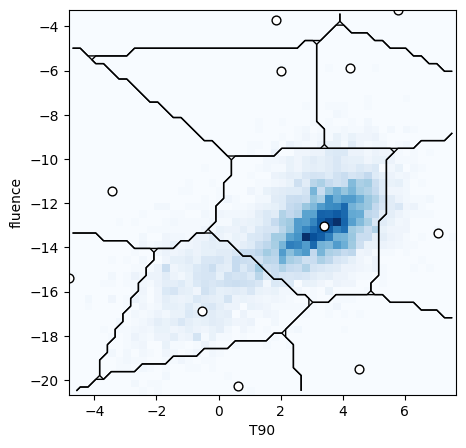

In [14]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('T90')
ax.set_ylabel('fluence')

plt.show()

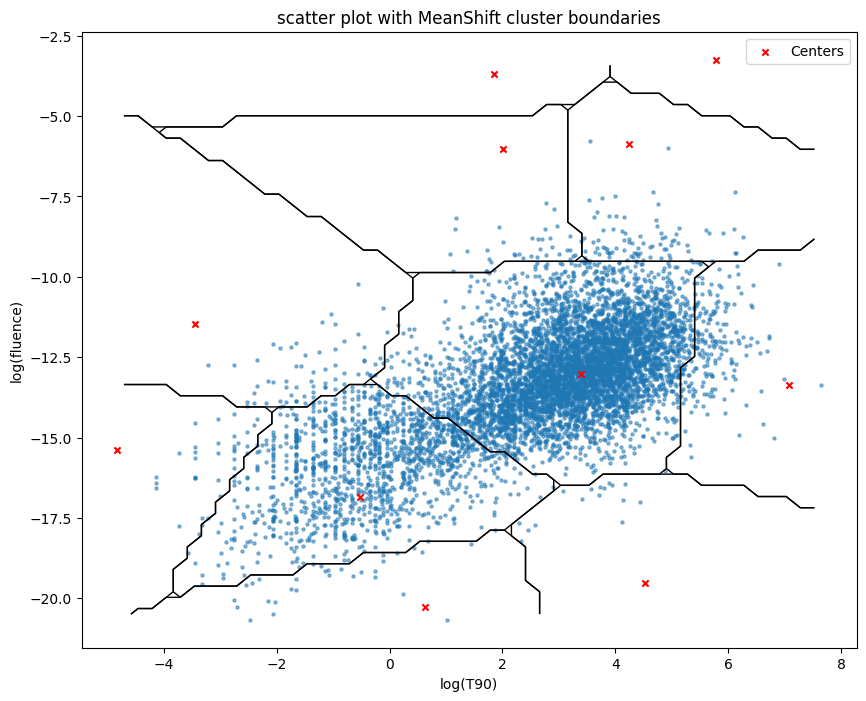

In [15]:
plt.figure(figsize=(10, 8))
labels = ms.predict(X) 

# plot the data color-coded by cluster id
colors = sns.color_palette("Paired")

plt.scatter(X[:, 0], X[:, 1], alpha=0.5, s=5)

# plot the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', marker='x', s=20, label='Centers')

# plot the cluster boundaries
for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0
    plt.contour(x_centers, y_centers, Hcp, [-0.5, 0.5], linewidths=1, colors='k')

plt.xlabel('log(T90)')
plt.ylabel('log(fluence)')
plt.legend()
plt.title('scatter plot with MeanShift cluster boundaries')
plt.show()

### If one wanted to look at other variables:

In [16]:
z

array([-999., -999., -999., ..., -999., -999., -999.])

In [17]:
z_mask = z > 0
fluence_mask = fluence > 0
mask_2 = z_mask & fluence_mask

z_masked = np.array( z[mask_2], dtype = float)
fluence_masked_2 = np.array(fluence[mask_2], dtype = float)

print(z_masked.shape, fluence_masked.shape)

(586,) (7348,)


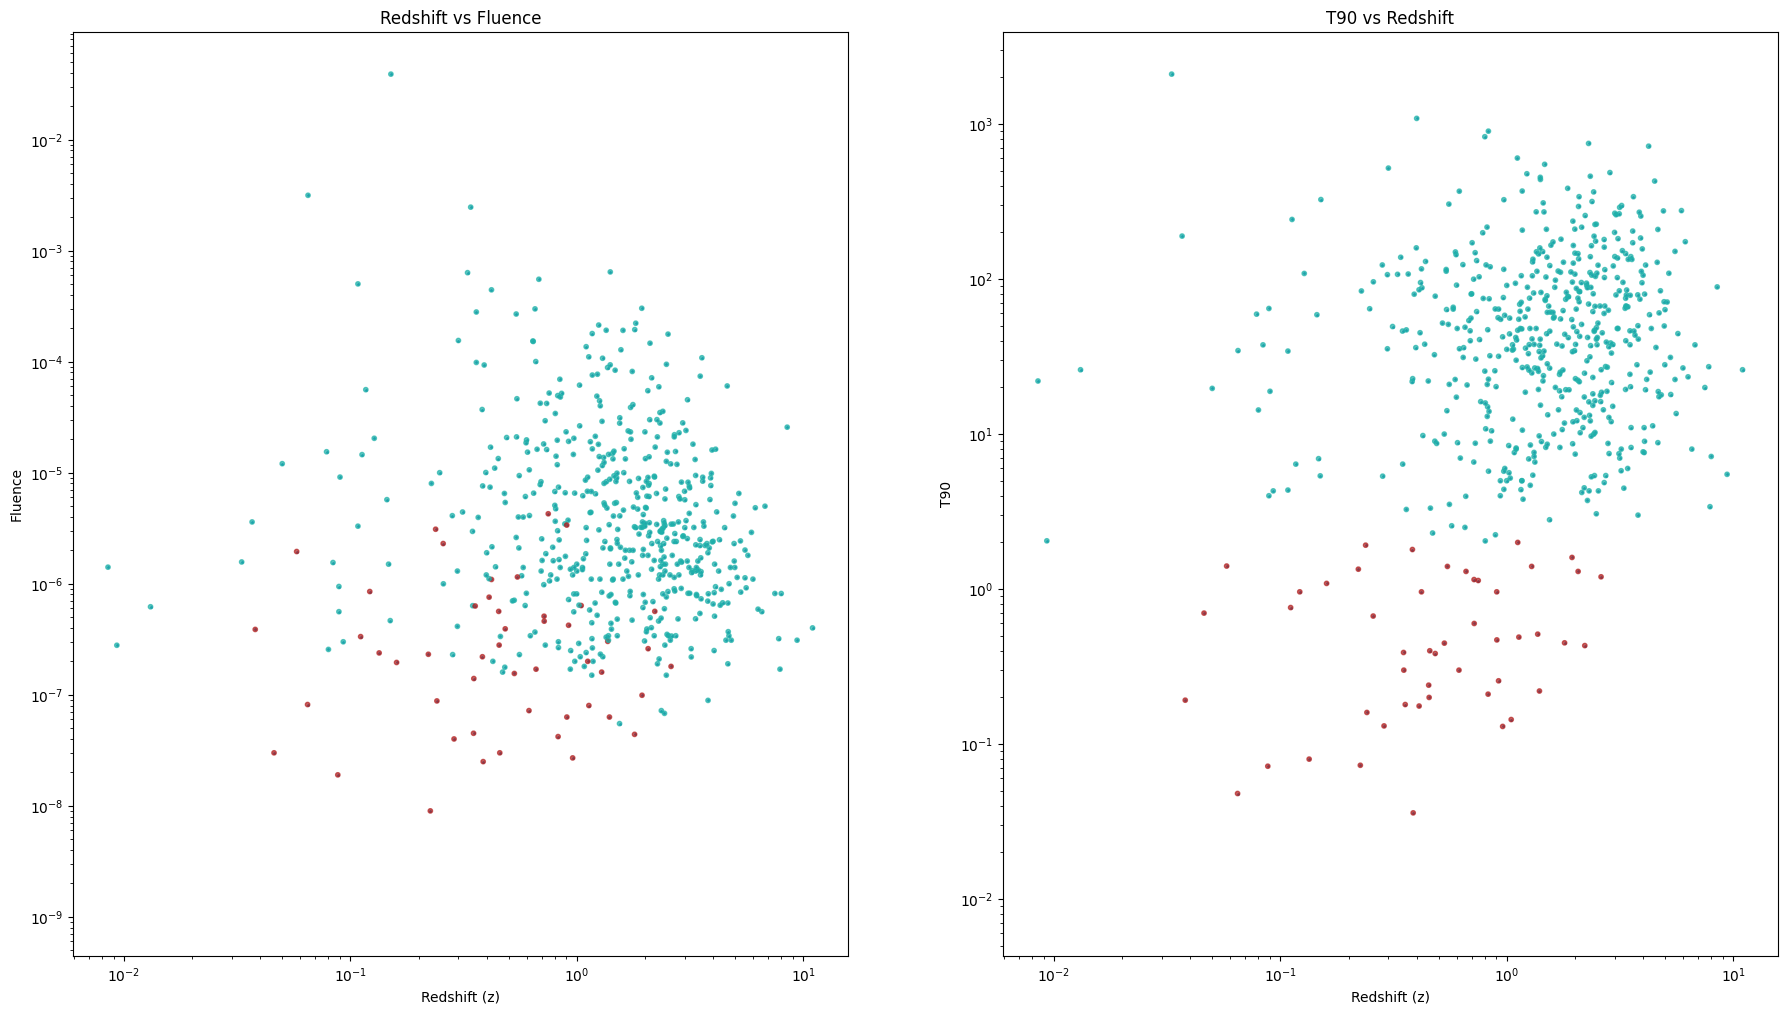

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(22, 12))

# Plot for Redshift vs Fluence
axs[0].scatter(z[T90_mask], fluence[T90_mask], s=1)
axs[0].set_xlabel('Redshift (z)')
axs[0].set_ylabel('Fluence')
axs[0].set_title('Redshift vs Fluence')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

colors = ['lightseagreen' if t > 2 else 'firebrick' for t in T90[T90_mask]]
axs[0].scatter(z[T90_mask], fluence[T90_mask], s=10, c=colors, alpha=0.7)

# Plot for Redshift vs T90
axs[1].scatter( z[T90_mask],T90[T90_mask], s=1)
axs[1].set_ylabel('T90')
axs[1].set_xlabel('Redshift (z)')
axs[1].set_title('T90 vs Redshift')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

colors = ['lightseagreen' if t > 2 else 'firebrick' for t in T90[T90_mask]]
axs[1].scatter(z[T90_mask],T90[T90_mask], s=10, c=colors, alpha=0.7)



### trying to do the clustering with redshift vs T90--> cannot find the bimodality

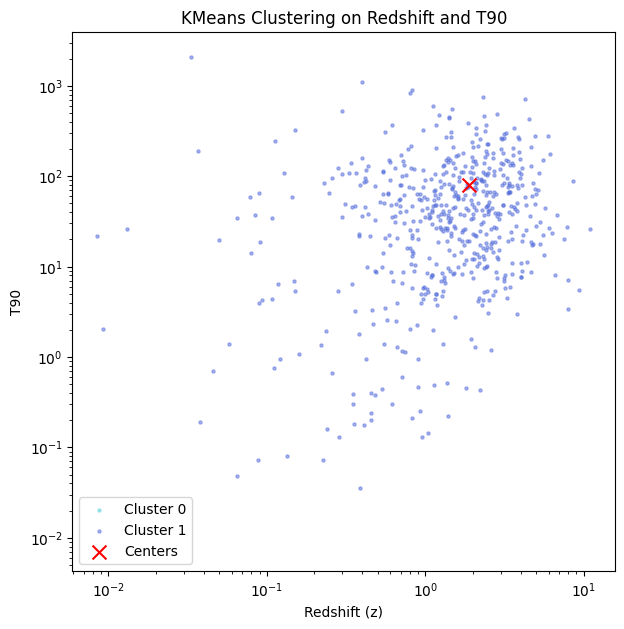

In [21]:
X_kmeans = np.array([z[T90_mask], T90[T90_mask]]).T

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_kmeans)
labels_kmeans = kmeans.predict(X_kmeans)
centers_kmeans = kmeans.cluster_centers_

plt.figure(figsize=(7, 7))

colors = sns.color_palette("hls", 8)[4:]
for i in range(2):
    plt.scatter(X_kmeans[labels_kmeans == i, 0], X_kmeans[labels_kmeans == i, 1], 
                color=colors[i], alpha=0.5, s=5, label=f'Cluster {i}')

plt.scatter(centers_kmeans[:, 0], centers_kmeans[:, 1], color='red', marker='x', s=100, label='Centers')

plt.xlabel('Redshift (z)')
plt.ylabel('T90')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('KMeans Clustering on Redshift and T90')
plt.show()

## Let's try to do dimentionality reduction

In [47]:
from sklearn.decomposition import PCA
import seaborn as sns

z_mask = z > 0

mask_all = T90_mask & fluence_mask & z_mask

X = np.array([np.log(T90[mask_all]), np.log(fluence[mask_all]), z[mask_all]]).T
print("initial shape of the datatset: ",X.shape)

pca= PCA() # n_components can be optionally set
pca.fit(X) 

eigenvalues = pca.transform(X) # compute the subspace projection of X, 4 eigenvalues for each of the 100 samples
mean = pca.mean_ # length 10 mean of the data
eigenvectors = pca.components_ # 4x10 matrix of components, multiply each by respective eigenvalue to reconstruct
evals = pca.explained_variance_ratio_ 

# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

print("new shape:", eigenvalues.shape)
print(eigenvectors.shape)

print('Explained fractional variance of data encapsulated in the eigenvalues: ' + str(evals), "\nsum: ", np.sum(evals))

initial shape of the datatset:  (573, 3)
new shape: (573, 3)
(3, 3)
Explained fractional variance of data encapsulated in the eigenvalues: [0.57588387 0.28221224 0.14190389] 
sum:  0.9999999999999999


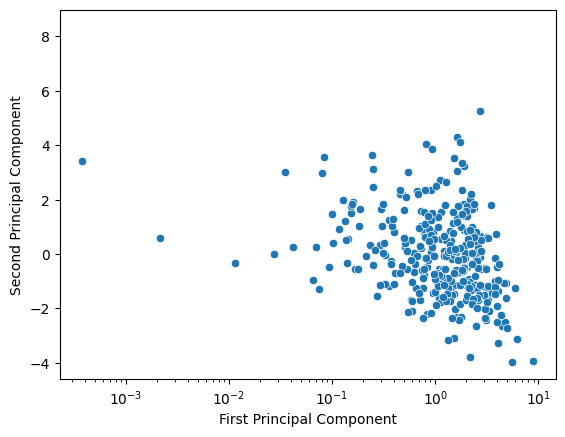

In [48]:
sns.scatterplot( x= eigenvalues[:,0], y= eigenvalues[:,1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.xscale('log')
#plt.yscale('log')


(573, 2)
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
0.5
number of estimated clusters : 20


'\n# MeanShift plot\naxs[1].set_title(\'MeanShift Clustering\')\nlabels = ms.predict(X_clusters)\ncolors = sns.color_palette("Paired")\naxs[1].scatter(X_clusters[:, 0], X_clusters[:, 1], alpha=0.5, s=5)\naxs[1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], color=\'red\', marker=\'x\', s=20, label=\'Centers\')\nfor i in range(n_clusters):\n    Hcp = H.copy()\n    flag = (Hcp == i)\n    Hcp[flag] = 1\n    Hcp[~flag] = 0\n    axs[1].contour(x_centers, y_centers, Hcp, [-0.5, 0.5], linewidths=1, colors=\'k\')\naxs[1].set_xlabel(\'First Principal Component\')\naxs[1].set_ylabel(\'Second Principal Component\')\naxs[1].legend()\n\nplt.show()\n'

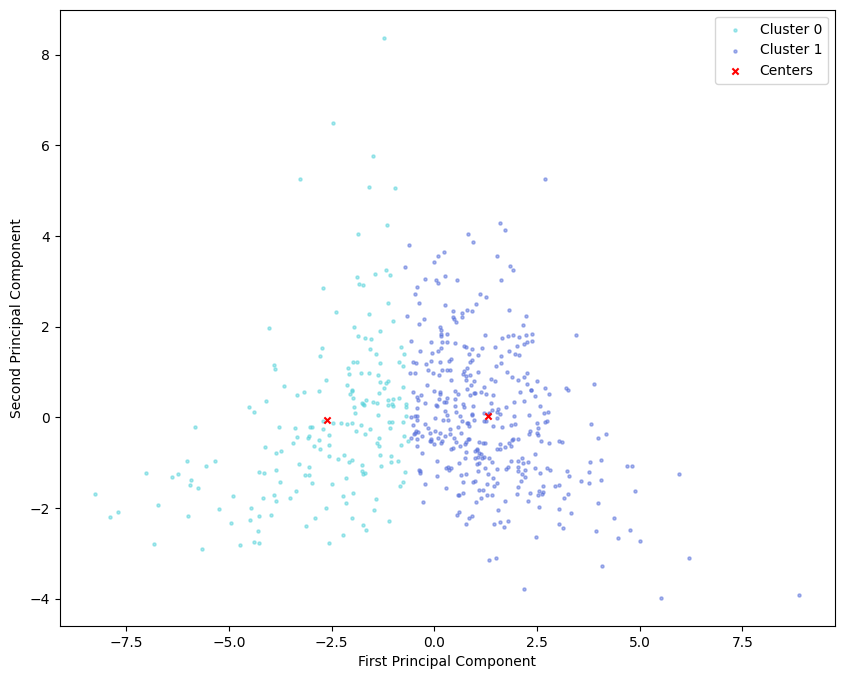

In [55]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

X_clusters = np.array([eigenvalues[:,0],eigenvalues[:,1]]).T
print(X_clusters.shape)

#KMeans
clf = KMeans(2) 
clf.fit(X_clusters)
centers = clf.cluster_centers_ 
labels = clf.predict(X_clusters) 

#MeanShift
scaler = preprocessing.StandardScaler()
bandwidth = 0.5
#bandwidth = estimate_bandwidth(X_reduced) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(X_clusters))
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)


#------------------------------------------------------------------------


#fig, axs = plt.subplots(1, 2, figsize=(18, 8))

fig, axs = plt.subplots(1, 1, figsize=(10, 8))

# KMeans plot
colors = sns.color_palette("hls", 8)[4:]
for ii in range(2):
    axs.scatter(X_clusters[labels==ii,0], X_clusters[labels==ii,1], 
                   color=colors[ii], alpha=0.5, s=5, label='Cluster %i' % ii)
axs.scatter(centers[:,0], centers[:,1], color='red', marker='x', s=20, label='Centers')
axs.set_xlabel('First Principal Component')
axs.set_ylabel('Second Principal Component')
axs.legend()

'''
# MeanShift plot
axs[1].set_title('MeanShift Clustering')
labels = ms.predict(X_clusters)
colors = sns.color_palette("Paired")
axs[1].scatter(X_clusters[:, 0], X_clusters[:, 1], alpha=0.5, s=5)
axs[1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', marker='x', s=20, label='Centers')
for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0
    axs[1].contour(x_centers, y_centers, Hcp, [-0.5, 0.5], linewidths=1, colors='k')
axs[1].set_xlabel('First Principal Component')
axs[1].set_ylabel('Second Principal Component')
axs[1].legend()

plt.show()
'''

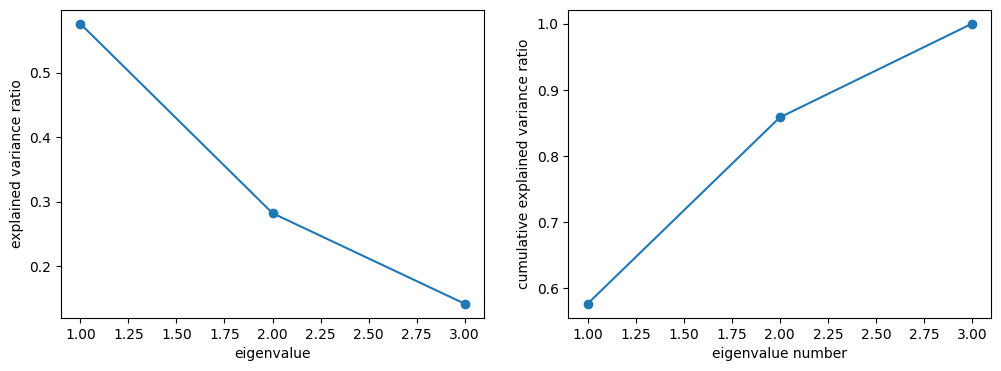

In [41]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)


n_components= np.ones(len(pca.explained_variance_ratio_ )) + range(len(pca.explained_variance_ratio_ ))

ax.plot(n_components, evals)
ax.scatter(n_components, evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")

ax = fig.add_subplot(122)

ax.plot(n_components, evals.cumsum())
ax.scatter(n_components, evals.cumsum())

ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")

plt.show()

In [33]:
print("The first component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[0]))
print("The second component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[1]))
#print("All components explain {:.3f} of the variance in the data.".format(sum(pca.explained_variance_ratio_)))

The first component explains 0.576 of the variance in the data.
The second component explains 0.282 of the variance in the data.


initial shape of the datatset:  (573, 6)
new shape: (573, 6)
(6, 6)
Explained fractional variance of data encapsulated in the eigenvalues: [8.08469575e-01 1.69597584e-01 2.18085624e-02 6.70830200e-05
 3.87165163e-05 1.84787232e-05] 
sum:  1.0


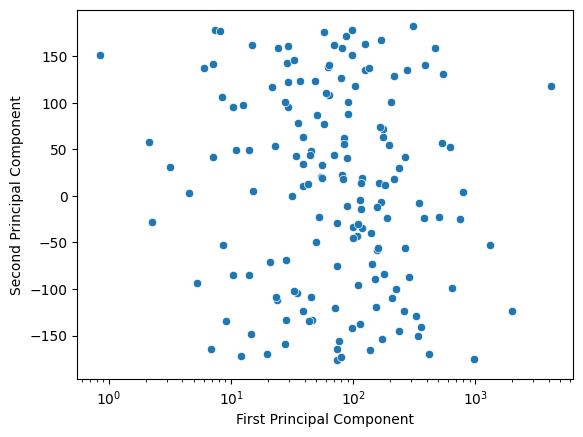

In [35]:
# with all the components the clustering is not very clear, but let's have a look at the PCA:

X = np.array([np.log(T90[mask_all]), np.log(fluence[mask_all]), z[mask_all], ra[mask_all], decl[mask_all], T100[mask_all]]).T
print("initial shape of the datatset: ",X.shape)

pca= PCA() # n_components can be optionally set
pca.fit(X) 

eigenvalues = pca.transform(X) # compute the subspace projection of X, 4 eigenvalues for each of the 100 samples
mean = pca.mean_ # length 10 mean of the data
eigenvectors = pca.components_ # 4x10 matrix of components, multiply each by respective eigenvalue to reconstruct
evals = pca.explained_variance_ratio_ 

# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

print("new shape:", eigenvalues.shape)
print(eigenvectors.shape)

print('Explained fractional variance of data encapsulated in the eigenvalues: ' + str(evals), "\nsum: ", np.sum(evals))

sns.scatterplot( x= eigenvalues[:,0], y= eigenvalues[:,1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.xscale('log')
#plt.yscale('log')


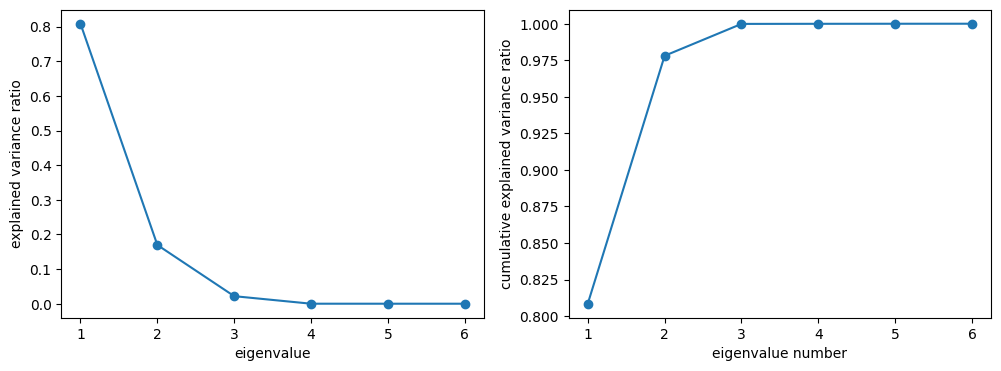

In [36]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)


n_components= np.ones(len(pca.explained_variance_ratio_ )) + range(len(pca.explained_variance_ratio_ ))

ax.plot(n_components, evals)
ax.scatter(n_components, evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")

ax = fig.add_subplot(122)

ax.plot(n_components, evals.cumsum())
ax.scatter(n_components, evals.cumsum())

ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")

plt.show()

In [37]:
print("The first component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[0]))
print("The second component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[1]))
#print("All components explain {:.3f} of the variance in the data.".format(sum(pca.explained_variance_ratio_)))

The first component explains 0.808 of the variance in the data.
The second component explains 0.170 of the variance in the data.
